# Section 1: Loading dataset and organising Data Augmentation

In this section, I have used a boilerplate loading structure from a Computer Vision Assignment 4, 2022, rather than the ones seen in the pytorch documentation and in workshop 2. As I have recently completed a similar assignment in Computer Vision (different dataset of course), I will aim to reuse a lot of helper functions implemented in that assignment, while focusing on different architectural designs and experiments. 

In [ ]:
%matplotlib inline
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR100
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import random_split
from torchsummary import summary 
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import pickle
!pip install adabound 
from torch.utils.data.dataloader import DataLoader
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os

python_files = "/content/drive/My Drive"
sys.path.append(os.path.abspath(python_files))

In [ ]:
from utils import *
from baseline import *
from models import *

In [ ]:
#we will keep transforms to a minimum at the moment
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
                                    
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform= transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#grab mean and std for transform normalisation
def mean_and_std(data):
  array_mean_std = []
  for i in range(3):
    channel = [np.asarray(data[n][0][0][i]) for n in range(len(data))]
    mean = np.mean(channel)
    std = np.std(channel)
    array_mean_std.append((mean, std))
  return array_mean_std


In [ ]:
training = mean_and_std(trainset)
testing = mean_and_std(testset)

In [ ]:
print(f'Training Mean and STD across image channels: {training}')

Training Mean and STD across image channels: [(0.5380107, 0.2989031), (0.53289795, 0.29278657), (0.5309344, 0.2874587)]


In [ ]:
print(f'Testing Mean and STD across image channels: {testing}')

Testing Mean and STD across image channels: [(0.54190314, 0.29984388), (0.53576, 0.293542), (0.5340833, 0.2883355)]


In [ ]:
trainset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [ ]:
val_size = len(trainset)// 5
train_size = len(trainset) - val_size

train_data, val_data = random_split(trainset, [train_size, val_size])

In [ ]:
print("Training, Validation and Testing Sizes")
print("---------------------------------------")
print(f"Training: {len(train_data)}")
print(f"Validation: {len(val_data)}")
print(f"Testing: {len(testset)}")

Training, Validation and Testing Sizes
---------------------------------------
Training: 40000
Validation: 10000
Testing: 10000


In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
device = get_default_device()
device
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)


In [ ]:
a = iter(train_loader)
a, b = next(a)

a[0].shape

torch.Size([3, 32, 32])

tensor([22, 21, 38, 39, 19, 58, 85, 25,  6, 60, 96, 57, 87, 20, 54, 99, 94, 75,
        35, 21, 18, 28, 98, 31, 39, 55, 61, 43, 62, 51, 57, 53, 48, 24, 37, 29,
        34, 41, 66, 52,  4, 15, 56, 49, 34, 58, 24, 98,  7, 56, 10,  1, 93, 19,
        86, 63, 89, 92,  0,  6, 21, 76,  1, 90, 92, 20, 72, 33, 10, 47, 71, 12,
        80, 48, 21, 95, 13, 98, 88, 75, 21, 91, 62, 86, 71, 29,  1, 60, 14,  4,
        93, 77, 80, 30, 86, 13, 38, 51, 74, 79, 27, 34, 68, 69, 26, 12, 70, 38,
        57, 16, 95,  9, 80, 39, 98, 36, 53, 20, 51, 79, 29, 55, 50, 72, 18,  4,
        34, 79])


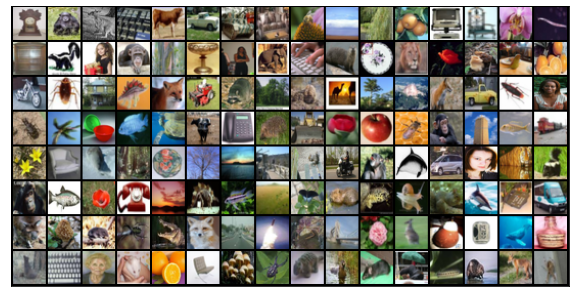

In [ ]:
for img, labels in train_loader:
  fig, ax = plt.subplots(figsize=(10,15))
  ax.set_yticks([])
  ax.set_xticks([])
  ax.imshow(torchvision.utils.make_grid(img, nrow=16).permute(1,2,0))
  print(labels)
  break

This next section is also from Computer Vision Assignment 4 2022, originally sourced from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E.


In [ ]:
 #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
!rm -rf download

--2022-10-25 00:51:23--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=dijl6aqtq19nf74cat38kjerp7; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=%2BnKml7NP%2FjR8TBUuwO0091HgyBxuAYWR5XO7b5d6uJiA%2BiYKL5Ncbj7CaB3ZKRu8Zal3sg4VBJrn2N0mSltpEPEEVurRqpie9%2F8LAp%2B0RFPwKXc67wqzB1huuqZSrioO; expires=Wed, 26-Oct-2022 00:51:24 GMT; Max-Age=86400; path=/plus;; Secure at position 226.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-10-25 00:51:24 (644 MB/s) - ‘download’ saved [5201/5201]



## Flop Count for Models

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 32, 32) # The input size should be the same as the size that you put into your model 
input2 = torch.randn(1,3,128,128)
input3 = torch.randn(1,3,224,224)
#vanilla
vcnn = VanillaCNN(3, num_classes = 100)
cnn = CNN(3, num_classes=100)
vit = ViT(3, num_classes = 100, img_size = 32, conv_feature_extractor=True)
vit2 = ViT(3, num_classes = 100, img_size = 128, conv_feature_extractor=True)
vit3 = ViT(3, num_classes = 100, img_size = 224, conv_feature_extractor=True)
resnet34 = ResNet34(3, num_classes = 100)
alex = PreTrained(num_classes=100)


In [ ]:
print('Vanilla CNN Flops:')
print_model_parm_flops(vcnn, input)
print('\nCNN Flops:')
print_model_parm_flops(cnn, input)
print('\n32x32x3 ViT Flops:')
print_model_parm_flops(vit, input)
print('\n128x128x3 ViT Flops:')
print_model_parm_flops(vit2, input2)
print('\n224x224x3 ViT Flops:')
print_model_parm_flops(vit3, input3)
print('\nResNet34 Flops:')
print_model_parm_flops(resnet34, input3)
print('\nAlexnet Flops:')
print_model_parm_flops(alex, input3)

Vanilla CNN Flops:
 + Number of FLOPs: 0.09G

CNN Flops:
 + Number of FLOPs: 0.14G

32x32x3 ViT Flops:
 + Number of FLOPs: 0.43G

128x128x3 ViT Flops:
 + Number of FLOPs: 5.58G

224x224x3 ViT Flops:
 + Number of FLOPs: 16.92G

ResNet34 Flops:
 + Number of FLOPs: 7.13G

Alexnet Flops:
 + Number of FLOPs: 1.39G


## Model Summaries



In [ ]:
vcnn.to(device)
summary(vcnn, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
            Conv2d-2          [-1, 128, 16, 16]          73,856
            Conv2d-3            [-1, 256, 8, 8]         295,168
            Linear-4                  [-1, 100]       1,638,500
Total params: 2,012,388
Trainable params: 2,012,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 7.68
Estimated Total Size (MB): 8.56
----------------------------------------------------------------


In [ ]:
cnn.to(device)
summary(cnn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
vit.to(device)
summary(vit, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 2, 2]         590,592
         Rearrange-2               [-1, 4, 768]               0
    PatchEmbedding-3               [-1, 5, 768]               0
         LayerNorm-4               [-1, 5, 768]           1,536
            Linear-5              [-1, 5, 2304]       1,771,776
           Dropout-6              [-1, 8, 5, 5]               0
            Linear-7               [-1, 5, 768]         590,592
MultiHeadAttention-8               [-1, 5, 768]               0
           Dropout-9               [-1, 5, 768]               0
      ResidualAdd-10               [-1, 5, 768]               0
        LayerNorm-11               [-1, 5, 768]           1,536
           Linear-12              [-1, 5, 3072]       2,362,368
             GELU-13              [-1, 5, 3072]               0
          Dropout-14              [-1, 

In [ ]:
alex.to(device)
summary(alex, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
resnet34.to(device)
summary(resnet34, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 18]           1,728
       BatchNorm2d-2           [-1, 64, 18, 18]             128
              ReLU-3           [-1, 64, 18, 18]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
          Identity-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,864
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
             ReLU-12             [-1, 64, 8, 8]               0
    ResidualBlock-13             [-1, 64, 8, 8]               0
         Identity-14             [-1, 6

In [ ]:
resnet12 = ResNet12(3, num_classes=100)
resnet12.to(device)

summary(resnet12, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 18]           1,728
       BatchNorm2d-2           [-1, 64, 18, 18]             128
              ReLU-3           [-1, 64, 18, 18]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
          Identity-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,864
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
             ReLU-12             [-1, 64, 8, 8]               0
    ResidualBlock-13             [-1, 64, 8, 8]               0
         Identity-14             [-1, 6

# Training and Validation

### 1.Vanilla CNN 

This implementation consists of no regularisation and batch normalisation.

In [ ]:
model_run_no = 0
model_run_no += 1
vanil = VanillaCNN(3, 100,model_run_no = model_run_no)



In [ ]:
epochs = 30
opt_func = 'Adam'
lr = 1e-3 

In [ ]:
vanilla_history = fit(vanil.to(device),
                  train_dl,
                  val_dl,
                  epochs=epochs,
                  lr=lr,
                  lr_scheduler='ROPlateau',
                  opt_func='Adam',
                  train_transforms = None,
                  val_transforms = None,
                  return_preds = False,

)

Epoch [0], train_loss: 3.6054, val_loss: 3.2532, val_acc: 0.4062
Epoch [5], train_loss: 1.0511, val_loss: 2.7825, val_acc: 0.5625
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch [10], train_loss: 0.0259, val_loss: 4.7253, val_acc: 0.5938
Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.
Epoch [15], train_loss: 0.0044, val_loss: 6.9493, val_acc: 0.6094
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.
Epoch [20], train_loss: 0.0034, val_loss: 5.6436, val_acc: 0.6172
Epoch 00026: reducing learning rate of group 0 to 6.2500e-05.
Epoch [25], train_loss: 0.0027, val_loss: 6.5672, val_acc: 0.6016
Training Duration: 2.77 minutes.


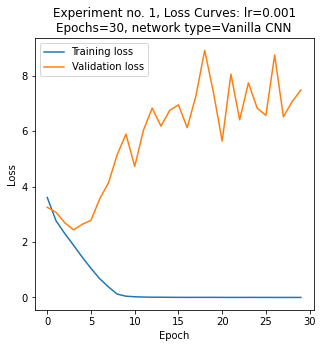

In [ ]:
loss_curves(vanilla_history,
            experiment_no = 1,
            epochs= 30,
            network='Vanilla CNN')

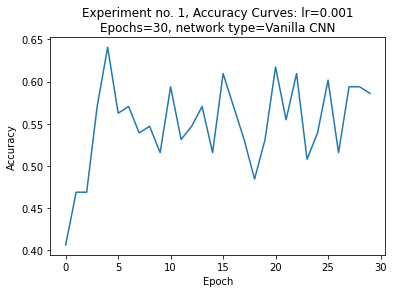

In [ ]:
accuracy_curves(vanilla_history,
            experiment_no = 1,
            epochs= 30,
            network='Vanilla CNN')

**Testing**

In [ ]:
model_path = "/content/model:Vanilla CNN, Run:1.pt"
vanil.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test_history = evaluate(vanil, test_dl, val_transforms = None, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {vanil.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for Vanilla CNN:
Accuracy--0.5703
Loss--7.0631


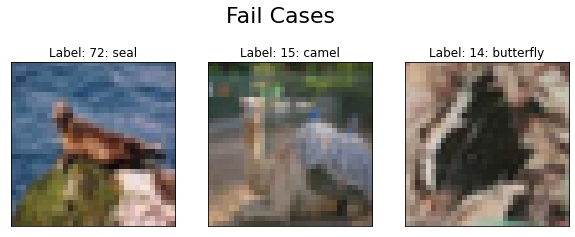

In [ ]:
show_failcase(testset, test_history)


### 2.Optimised CNN - Max Pool

This implementation consists of regularisation via data augmentation, batch normalisation and dropout. This model also has far more parameters. 

In [ ]:
model_run_no += 1
conv = CNN(input_channels= 3, 
            num_classes= 100,
            model_run_no = model_run_no)

In [ ]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.33),
            transforms.RandomAffine(degrees=13, translate=(0.0,0.2), scale=(0.8,1.4), shear=0, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5380107,0.53289795,0.5309344), (0.2989031, 0.29278657, 0.2874587))
        ])

val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.54190314, 0.53576, 0.5340833 ), (0.29984388, 0.293542, 0.2883355))
        ])

In [ ]:
conv_history = fit(conv.to(device),
                  train_dl,
                  val_dl,
                  epochs=epochs,
                  lr=lr,
                  lr_scheduler='ROPlateau',
                  opt_func='Adam',
                  train_transforms = train_transforms,
                  val_transforms = val_transforms,
                  return_preds = False,

)

Epoch [0], train_loss: 4.1146, val_loss: 3.7425, val_acc: 0.2422
Epoch [5], train_loss: 2.7000, val_loss: 2.8603, val_acc: 0.4531
Epoch [10], train_loss: 2.2393, val_loss: 2.4062, val_acc: 0.6328
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15], train_loss: 1.8636, val_loss: 2.2228, val_acc: 0.5703
Epoch [20], train_loss: 1.6994, val_loss: 1.9736, val_acc: 0.7188
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.
Epoch [25], train_loss: 1.4976, val_loss: 2.1795, val_acc: 0.6562
Training Duration: 9.82 minutes.


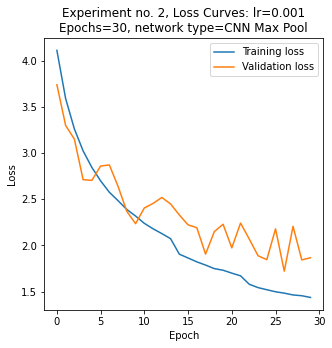

In [ ]:
loss_curves(conv_history,
            experiment_no = 2,
            epochs= 30,
            network='CNN Max Pool')

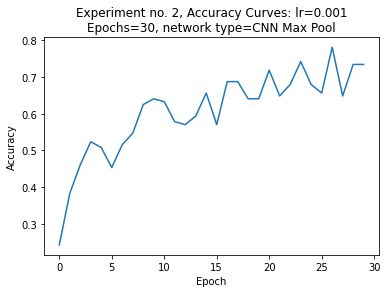

In [ ]:
accuracy_curves(conv_history,
               experiment_no=2,
               epochs=30,
               network=('CNN Max Pool'))

In [ ]:

model_path = "/content/model:Optimised CNN, Run:2.pt"
conv.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test_history =evaluate(conv, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {conv.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for Optimised CNN:
Accuracy--0.6875
Loss--1.9014


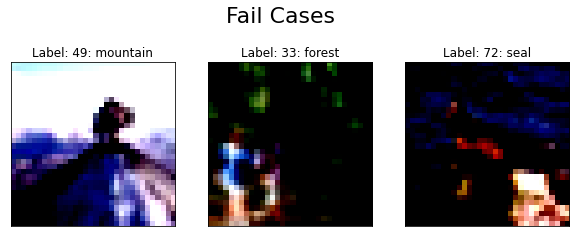

In [ ]:
show_failcase(testset, test_history)



### 2.Optimised CNN - Average Pooling

In [ ]:
model_run_no += 1
conv1 = CNN(input_channels= 3, 
            num_classes= 100,
            model_run_no = model_run_no, 
            max_pool=False)

In [ ]:
conv1_history = fit(conv1.to(device),
                  train_dl,
                  val_dl,
                  epochs=epochs,
                  lr=lr,
                  lr_scheduler='ROPlateau',
                  opt_func='Adam',
                  train_transforms = train_transforms,
                  val_transforms = val_transforms,
                  return_preds = False,

)

Epoch [0], train_loss: 4.1229, val_loss: 4.1234, val_acc: 0.1641
Epoch [5], train_loss: 2.8623, val_loss: 3.0324, val_acc: 0.4219
Epoch [10], train_loss: 2.3394, val_loss: 2.5512, val_acc: 0.5625
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15], train_loss: 1.8985, val_loss: 2.1634, val_acc: 0.6016
Epoch [20], train_loss: 1.7030, val_loss: 1.8954, val_acc: 0.7031
Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.
Epoch [25], train_loss: 1.4654, val_loss: 1.7165, val_acc: 0.7500
Training Duration: 9.90 minutes.


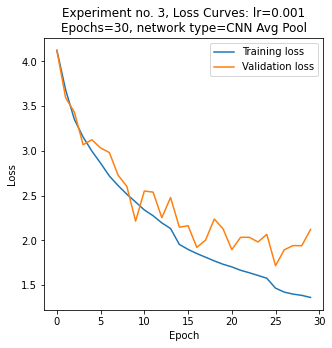

In [ ]:
loss_curves(conv1_history,
            experiment_no = 3,
            epochs= 30,
            network='CNN Avg Pool')

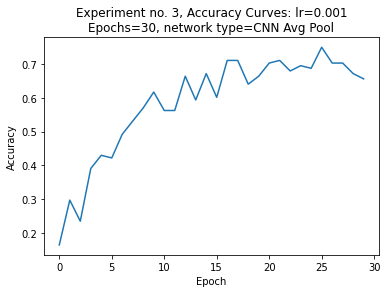

In [ ]:
accuracy_curves(conv1_history,
               experiment_no=3,
               epochs=30,
               network=('CNN Avg Pool'))

In [ ]:
model_path = "/content/model:Optimised CNN, Run:3.pt"
conv1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_history =evaluate(conv1, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {conv1.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for Optimised CNN:
Accuracy--0.7266
Loss--1.8884


### 3. ResNet12

In [ ]:
model_run_no += 1
resnet12 = ResNet12(3, num_classes=100, model_run_no=model_run_no)
epochs=30
lr=1e-3

In [ ]:
res12_history = fit(resnet12.to(device),
                  train_dl,
                  val_dl,
                  epochs=epochs,
                  lr=lr,
                  lr_scheduler='ROPlateau',
                  opt_func='Adam',
                  train_transforms = train_transforms,
                  val_transforms = val_transforms,
                  return_preds = False,

)

Epoch [0], train_loss: 3.8253, val_loss: 3.5608, val_acc: 0.3359
Epoch [5], train_loss: 2.6464, val_loss: 2.6000, val_acc: 0.5234
Epoch [10], train_loss: 2.2578, val_loss: 2.4522, val_acc: 0.5859
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15], train_loss: 1.9883, val_loss: 2.4098, val_acc: 0.6328
Epoch [20], train_loss: 1.6475, val_loss: 2.0829, val_acc: 0.6875
Epoch [25], train_loss: 1.4918, val_loss: 2.1781, val_acc: 0.6875
Training Duration: 10.88 minutes.


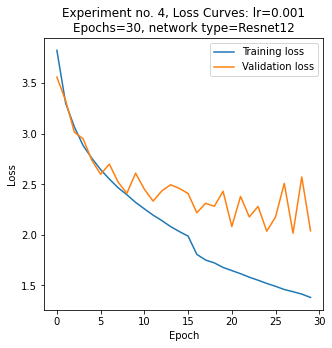

In [ ]:
loss_curves(res12_history,
            experiment_no=4,
            epochs=30,
            network=('Resnet12'))

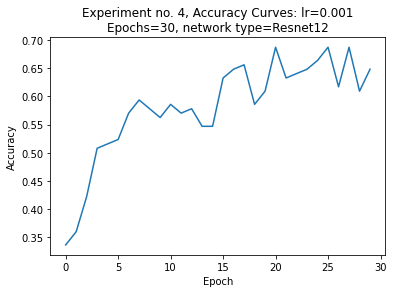

In [ ]:
accuracy_curves(res12_history,
                experiment_no=4,
                epochs=30,
                network=('Resnet12'))

**Testing Performance**

In [ ]:
model_path = "/content/model:resnet12, Run:4.pt"
resnet12.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
test_history =evaluate(resnet12, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {resnet12.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for resnet12:
Accuracy--0.6016
Loss--2.6915


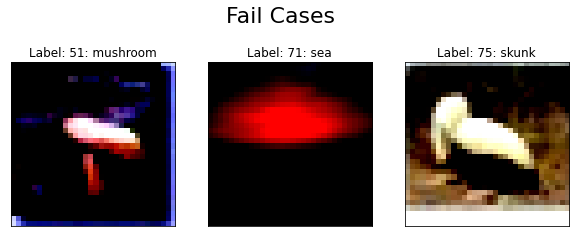

In [ ]:
show_failcase(testset, test_history)

### 4. ResNet34


In [ ]:
model_run_no += 1
resnet34 = ResNet34(3, num_classes=100, model_run_no=model_run_no)


In [ ]:
res34_history = fit(resnet34.to(device),
                  train_dl,
                  val_dl,
                  epochs=epochs,
                  lr=lr,
                  lr_scheduler='ROPlateau',
                  opt_func='Adam',
                  train_transforms = train_transforms,
                  val_transforms = val_transforms,
                  return_preds = False,

)

Epoch [0], train_loss: 4.1159, val_loss: 4.0284, val_acc: 0.2500
Epoch [5], train_loss: 3.0599, val_loss: 3.0286, val_acc: 0.4219
Epoch [10], train_loss: 2.6331, val_loss: 2.8344, val_acc: 0.4766
Epoch [15], train_loss: 2.3193, val_loss: 2.1927, val_acc: 0.6484
Epoch [20], train_loss: 2.0416, val_loss: 3.2075, val_acc: 0.6016
Epoch 00022: reducing learning rate of group 0 to 5.0000e-04.
Epoch [25], train_loss: 1.6236, val_loss: 2.5512, val_acc: 0.5781
Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.
Training Duration: 14.04 minutes.


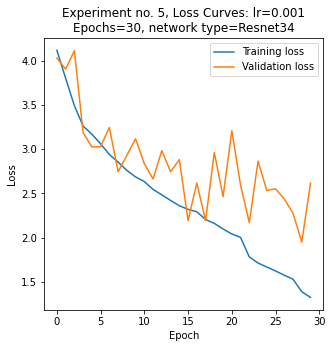

In [ ]:
loss_curves(res34_history,
            experiment_no=5,
            epochs=30,
            network=('Resnet34'))

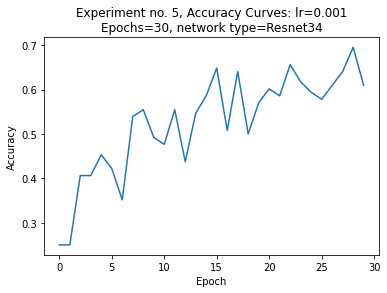

In [ ]:
accuracy_curves(res34_history,
                experiment_no=5,
                epochs=30,
                network=('Resnet34'))

**Testing**

In [ ]:
model_path = "/content/model:resnet34, Run:5.pt"
resnet34.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_history = evaluate(resnet34, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {resnet34.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for resnet34:
Accuracy--0.5703
Loss--2.6920


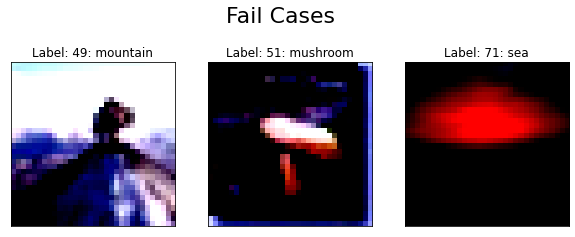

In [ ]:
show_failcase(testset, test_history)

### ViT Linear Feature Extraction



In [ ]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.33),
            transforms.RandomAffine(degrees=13, translate=(0.0,0.2), scale=(0.8,1.4), shear=0, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5380107,0.53289795,0.5309344), (0.2989031, 0.29278657, 0.2874587))
        ])

val_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.54190314, 0.53576, 0.5340833 ), (0.29984388, 0.293542, 0.2883355))
        ])

In [ ]:
model_run_no += 1
lin_vit = ViT(in_channels = 3,
            patch_size = 16,
            emb_size = 768,
            img_size = 32, #make sure this is a multiple of patch_size
            depth = 6, 
            num_classes = 100,
            model_run_no = model_run_no,
            model_name = "vit_lin",
            conv_feature_extractor = False,
            )


In [ ]:
vitlin_history = fit(lin_vit.to(device), 
              train_dl, 
              val_dl, 
              epochs = epochs,
              lr = lr,
              lr_scheduler='ROPlateau',
              opt_func = 'Adam',
              train_transforms = train_transforms,
              val_transforms = val_transforms
              ) 

Epoch [0], train_loss: 4.3857, val_loss: 4.0805, val_acc: 0.1250
Epoch [5], train_loss: 3.9011, val_loss: 3.7174, val_acc: 0.3125
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Epoch [10], train_loss: 3.7846, val_loss: 3.7747, val_acc: 0.2656
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Epoch [15], train_loss: 3.7071, val_loss: 3.7402, val_acc: 0.2656
Epoch [20], train_loss: 3.6593, val_loss: 3.7595, val_acc: 0.2109
Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.
Epoch [25], train_loss: 3.6009, val_loss: 3.5576, val_acc: 0.3516
Epoch 00028: reducing learning rate of group 0 to 6.2500e-05.
Training Duration: 12.76 minutes.


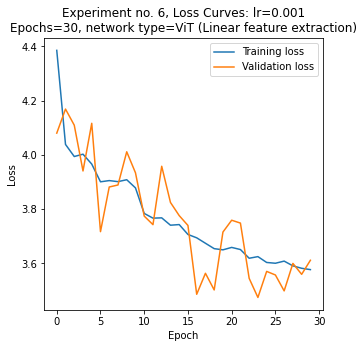

In [ ]:
loss_curves(vitlin_history,
            experiment_no=6,
            epochs=30,
            network='ViT (Linear feature extraction)')

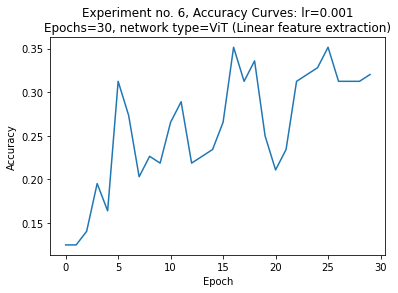

In [ ]:
accuracy_curves(vitlin_history,
            experiment_no=6,
            epochs=30,
            network='ViT (Linear feature extraction)')

In [ ]:
model_path = "/content/model:vit_lin, Run:6.pt"
lin_vit.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_history = evaluate(lin_vit, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {lin_vit.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for vit_lin:
Accuracy--0.3672
Loss--3.4689


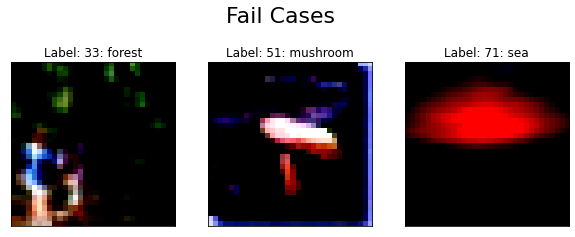

In [ ]:
show_failcase(testset, test_history)

### ViT Convolutional Feature Extraction

In [ ]:
model_run_no += 1
conv_vit = ViT(in_channels = 3,
            patch_size = 16,
            emb_size = 768,
            img_size = 32, #make sure this is a multiple of patch_size
            depth = 6, 
            num_classes = 100,
            model_run_no = model_run_no,
            model_name = "vit_conv",
            conv_feature_extractor = True,
            )

In [ ]:
vit_conv_history = fit(conv_vit.to(device), 
              train_dl, 
              val_dl, 
              epochs = epochs,
              lr = lr,
              lr_scheduler='ROPlateau',
              opt_func = 'Adam',
              train_transforms = train_transforms,
              val_transforms = val_transforms,
              return_preds=False
              ) 

Epoch [0], train_loss: 4.3900, val_loss: 4.2426, val_acc: 0.1328
Epoch [5], train_loss: 3.9856, val_loss: 3.9643, val_acc: 0.1953
Epoch [10], train_loss: 3.9099, val_loss: 3.8241, val_acc: 0.2500
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15], train_loss: 3.8187, val_loss: 3.6930, val_acc: 0.2656
Epoch 00021: reducing learning rate of group 0 to 2.5000e-04.
Epoch [20], train_loss: 3.7796, val_loss: 3.8566, val_acc: 0.2266
Epoch [25], train_loss: 3.6599, val_loss: 3.7189, val_acc: 0.2812
Epoch 00027: reducing learning rate of group 0 to 1.2500e-04.


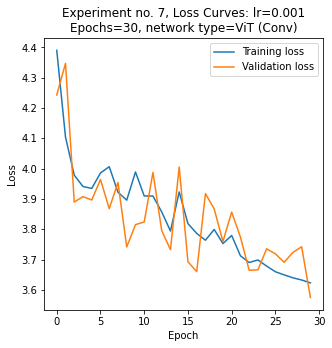

In [ ]:
loss_curves(vit_conv_history,
            experiment_no=7,
            epochs=30,
            network='ViT (Conv)')

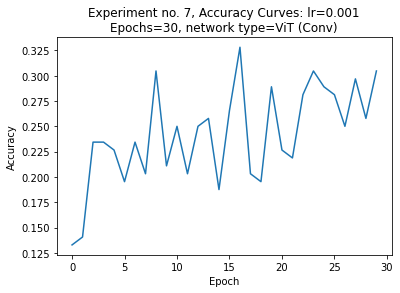

In [ ]:
accuracy_curves(vit_conv_history,
            experiment_no=7,
            epochs=30,
            network='ViT (Conv)')

**Testing**

In [ ]:
model_path = "/content/model:vit_conv, Run:7.pt"
conv_vit.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_history = evaluate(conv_vit, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {conv_vit.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for vit_conv:
Accuracy--0.3359
Loss--3.5189


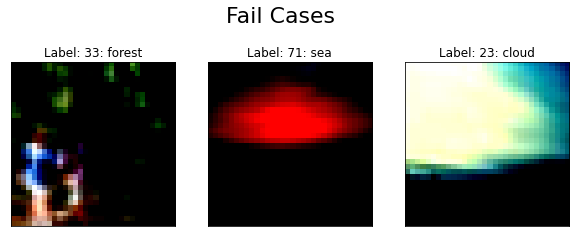

In [ ]:
show_failcase(testset, test_history)

### ViT on 128x128 images

In [ ]:
model_run_no += 1
large_vit = ViT(in_channels = 3,
            patch_size = 16,
            emb_size = 768,
            img_size = 128, #make sure this is a multiple of patch_size
            depth = 6, 
            num_classes = 100,
            model_run_no = model_run_no,
            model_name = "large_vit",
            conv_feature_extractor = True,
            )

In [ ]:
train_transforms = transforms.Compose([
            transforms.Resize(128), #must be multiple of patch size for vit
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.33),
            transforms.RandomAffine(degrees=13, translate=(0.0,0.2), scale=(0.8,1.4), shear=0, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5380107,0.53289795,0.5309344), (0.2989031, 0.29278657, 0.2874587))
        ])

val_transforms = transforms.Compose([
            transforms.Resize(128),
            transforms.ToTensor(),
            transforms.Normalize((0.54190314, 0.53576, 0.5340833 ), (0.29984388, 0.293542, 0.2883355))
        ])

In [ ]:
vit_large_history = fit(large_vit.to(device), 
              train_dl, 
              val_dl, 
              epochs = epochs,
              lr = lr,
              lr_scheduler='ROPlateau',
              opt_func = 'Adam',
              train_transforms = train_transforms,
              val_transforms = val_transforms,
              return_preds=False
              ) 

Epoch [0], train_loss: 4.3508, val_loss: 4.1662, val_acc: 0.1641
Epoch [5], train_loss: 3.8748, val_loss: 4.0828, val_acc: 0.1719
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch [10], train_loss: 3.6735, val_loss: 3.7301, val_acc: 0.2344
Epoch [15], train_loss: 3.5757, val_loss: 3.7178, val_acc: 0.2656
Epoch [20], train_loss: 3.5708, val_loss: 3.5257, val_acc: 0.2969
Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Epoch [25], train_loss: 3.4235, val_loss: 3.3692, val_acc: 0.3594
Epoch 00029: reducing learning rate of group 0 to 1.2500e-04.
Training Duration: 106.14 minutes.


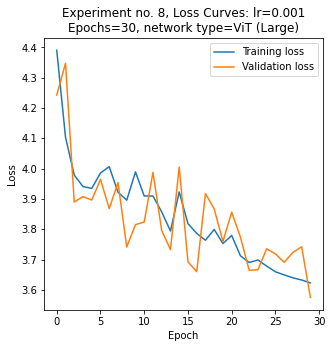

In [ ]:
loss_curves(vit_conv_history,
            experiment_no=8,
            epochs=30,
            network='ViT (Large)')

In [ ]:
test_history = evaluate(large_vit, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {large_vit.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for large_vit:
Accuracy--0.3984
Loss--3.1195


**Testing**


In [ ]:
model_path = "/content/model:large_vit, Run:8.pt"
large_vit.load_state_dict(torch.load(model_path))

<All keys matched successfully>

###Transfer Learning - AlexNet



In [ ]:
model_run_no += 1
alexnet1 = PreTrained(num_classes=100, model_run_no=model_run_no)

In [ ]:
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(p = 0.5),
            transforms.RandomVerticalFlip(p = 0.33),
            transforms.RandomAffine(degrees=13, translate=(0.0,0.2), scale=(0.8,1.4), shear=0, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5380107,0.53289795,0.5309344), (0.2989031, 0.29278657, 0.2874587))
        ])

val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.54190314, 0.53576, 0.5340833 ), (0.29984388, 0.293542, 0.2883355))
        ])

In [ ]:
alexnet_history = fit(alexnet1.to(device), 
              train_dl, 
              val_dl, 
              epochs = 30,
              lr = lr,
              lr_scheduler='ROPlateau',
              opt_func = 'Adam',
              train_transforms = train_transforms,
              val_transforms = val_transforms,
              return_preds=False
              ) 

Epoch [0], train_loss: 2.9847, val_loss: 2.2947, val_acc: 0.6094
Epoch [5], train_loss: 2.4619, val_loss: 2.3955, val_acc: 0.6094
Epoch [10], train_loss: 2.4268, val_loss: 2.3541, val_acc: 0.6016
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15], train_loss: 2.2128, val_loss: 2.3899, val_acc: 0.5938
Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.
Epoch [20], train_loss: 2.1366, val_loss: 2.0958, val_acc: 0.6797
Epoch 00025: reducing learning rate of group 0 to 1.2500e-04.
Epoch [25], train_loss: 2.0805, val_loss: 2.2069, val_acc: 0.6172
Training Duration: 86.32 minutes.


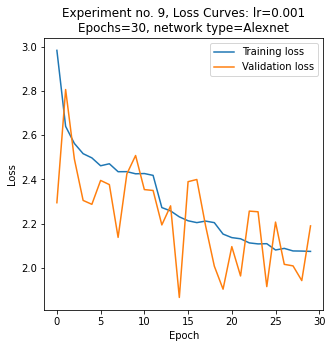

In [ ]:
loss_curves(alexnet_history,
            experiment_no=9,
            epochs=30,
            network='Alexnet')

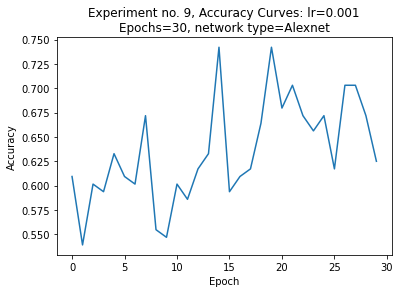

In [ ]:
accuracy_curves(alexnet_history,
            experiment_no=9,
            epochs=30,
            network='Alexnet')

**Testing**

In [ ]:
model_path = "/content/model:alexnet, Run:9.pt"
alexnet1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
test_history = evaluate(alexnet1, test_dl, val_transforms = val_transforms, test = True, return_preds=True)
test_acc = test_history[0]["test_top3_acc"]
test_loss = test_history[0]["test_loss"]
print (f"Testing performance for {alexnet1.model_name}:\nAccuracy--{test_acc:.4f}\nLoss--{test_loss:.4f}")

Testing performance for alexnet:
Accuracy--0.6875
Loss--2.0662


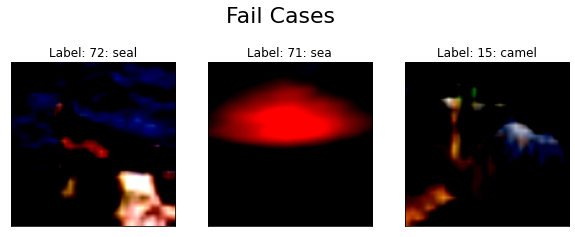

In [ ]:
show_failcase(testset, test_history)